# Try a Deep Convolutional Generative Adversarial Network on DDSM Dataset

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
from PIL import Image

import itertools


In [2]:
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Hyperparameters

In [3]:
# Root directory for dataset
dataroot='/clio/users/olgakr/DDSM/new_labels/3class/'
dataroot2= '/clio/users/olgakr/DDSM/ddsm_patches/'

dataroot3 = './ddsm_masks/train_masks/'  # mask path

# Number of workers for dataloader
num_workers = 32

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [4]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Mask Loader

### Load a Mask DataLoader based on the Augmented data

In [5]:
class MASKS(torch.utils.data.Dataset):
    def __init__(self, root,transform):
        self.root = root
        self.image_list = os.listdir(root)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image = Image.open(os.path.join(self.root,image_name))
    
        image = self.transform(image)
        
        return image
    
    
transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                               transforms.Resize([64,64]), 
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5], std=[0.5])
                           ])
mask_dataset = MASKS(dataroot3, transform=transform)

mask_loader = torch.utils.data.DataLoader(
        mask_dataset, batch_size=64, shuffle=True,
        num_workers=10, pin_memory=True)


     

In [6]:
mask_patch = next(iter(mask_loader))
np.place(mask_patch.numpy(),mask_patch.numpy()>-1, [1])
np.place(mask_patch.numpy(),mask_patch.numpy()==-1, [0])

In [7]:
print(torch.min(mask_patch))
print(torch.max(mask_patch))

tensor(0.)
tensor(1.)


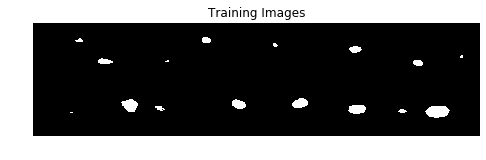

In [8]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(mask_patch.to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))

# This function adds the mask as a noise input on the mammogram data (without modifying the original images)

In [9]:
def createpatch(mydata, masks, batch_size):
    real = Variable(mydata.data.clone())
    mask = Variable(masks.data.clone())
    realdata = real[:batch_size]
    maskdata = mask[:batch_size]
    
    ## find the mask location
    maskpos = np.where(maskdata==1)
    
    #create index file
    indices = np.empty((maskpos[0].shape[0], len(maskpos)))
    for i in range(maskpos[0].shape[0]):
    
        indices[i] = np.array((maskpos[0][i],maskpos[1][i],maskpos[2][i], maskpos[3][i]))
    
    # transform real images to have a noise input
    
    for index in indices:
        realdata[int(index[0])][int(index[1])][int(index[2])][int(index[3])] = np.random.uniform(-1,1)
    
    return realdata

# Load the data & create a DataLoader

In [10]:
class DDSM(torch.utils.data.Dataset):
    def __init__(self, root1, root2, split, transform):
        self.root1 = root1
        self.root2 = root2
        def process_line(line):
            if 'normal' in line:
                image_name, label = line.strip().split(' ')
                label = int(label)
                return image_name, label
        with open(os.path.join(root1, '{}.txt'.format(split)), 'r') as f:
            for line in f:
                if 'normal' in line:
                    self.image_list = (list(map(process_line, f.readlines())))
            
        self.transform = transform

    def __len__(self):
        #print(len(self.image_list))
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name, label = self.image_list[idx]
        image = Image.open(os.path.join(self.root2, image_name)) #.convert("L")
        image = self.transform(image)
        
        return image, label
    

transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.Resize([64,64]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = DDSM(dataroot, dataroot2, 'train',  transform=transform)



train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

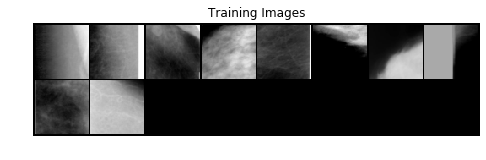

In [11]:


# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

In [12]:
real_batch[0].shape # G and D should generate and be fed with 28x28 images!!

torch.Size([64, 1, 64, 64])

In [13]:
olga = createpatch(real_batch[0], mask_patch, batch_size)

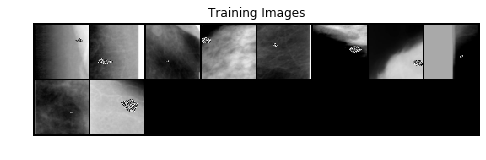

In [14]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(olga.to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
torch.max(real_batch[0])

tensor(1.)

In [16]:
torch.min(real_batch[0])

tensor(-1.)

#  Weight initialization for both Generator and Discriminator

In [17]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Class Adversarial AutoEncoder Generator

In [18]:
# Generator Code

class encoder(nn.Module):
    def __init__(self, ngpu):
        super(encoder, self).__init__()
        self.ngpu = ngpu
        #input 1x64x64
        self.conv1 = nn.Conv2d(2, ngf, 3, 1, 1, bias=False) # one channel for the image one for the mask
        self.bn1 = nn.BatchNorm2d(ngf)   
        #first layer ngf x 64 x 64
        self.conv2 = nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False)  # second layer will be concatenated (remember x and y)
        self.bn2 = nn.BatchNorm2d(ngf * 2)
        #second layer ngf*2 x 32 x 32
        self.conv3 = nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        #third layer ngf*4 x 16 x 16
        self.conv4 =  nn.Conv2d( ngf * 4, ngf * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf * 8)
        #forth layer ngf*8 x 8 x 8
        self.conv5 =  nn.Conv2d( ngf * 8, ngf * 16, 4, 2, 1, bias=False)
        
        #fifth layer ngf*16 x 4 x 4
            
    def forward(self, input, masking):
        x = torch.cat([input, masking], 1)
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        #print('1: ', x.shape)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        #print('2: ', x.shape)
        x = F.leaky_relu(self.bn3(self.conv3(x)),0.2)
        #print('3: ', x.shape)
        x = F.leaky_relu(self.bn4(self.conv4(x)),0.2)
        #print('4: ', x.shape)
        x = torch.tanh(self.conv5(x))
        #print('5: ', x.shape)
        return x
            
class decoder(nn.Module):
    def __init__(self, ngpu):
        super(decoder, self).__init__()
        self.ngpu = ngpu
            
        self.dec1 = nn.ConvTranspose2d((ndf*16)*2, ngf * 8, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        #1st layer ngf* 8 x 8 x 8
        self.dec2 = nn.ConvTranspose2d(ngf*8, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*4)
        #2nd layer ngf*4 x 16 x 16
        self.dec3 = nn.ConvTranspose2d(ngf*4, ngf * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*2)
        #3rd ngf*2 x 32 x 32
        self.dec4 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        #4th layer ngf x 64 x 64
        self.dec5 = nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False)
        #5th layer 1 x 64 x 64
     
    def forward(self, input, extranoise):
        x = torch.cat([input, extranoise], 1)
        x = F.relu(self.bn1(self.dec1(x)))
        #print('1: ', x.shape)
        x = F.relu(self.bn2(self.dec2(x)))
        #print('2: ', x.shape)
        x = F.relu(self.bn3(self.dec3(x)))
        #print('3: ', x.shape)
        x = F.relu(self.bn4(self.dec4(x)))
        #print('4: ', x.shape)
        x = torch.tanh(self.dec5(x))
        #print('5: ', x.shape)

        return x

In [19]:
# Create the encoder
encoder = encoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    encoder = nn.DataParallel(encoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
encoder.apply(weights_init)

# Print the model
print(encoder)

DataParallel(
  (module): encoder(
    (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


In [20]:
# Create the decoder
decoder = decoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    decoder = nn.DataParallel(decoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
decoder.apply(weights_init)

# Print the model
print(decoder)

DataParallel(
  (module): decoder(
    (dec1): ConvTranspose2d(2048, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec5): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)


# Linear projection of Gaussian distribution

In [21]:
class Projection(nn.Module):
    def __init__(self, ngpu):
        super(Projection, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(nz, ndf*8),
            nn.ReLU(True),
            nn.Linear(ndf*8, ndf*16*4*4),
            nn.Tanh())
    def forward(self, input):
        return self.main(input)
            

In [22]:


netp = Projection(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netp = nn.DataParallel(netp, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netp.apply(weights_init)

# Print the model
print(netp)

p_optimizer = torch.optim.Adam(netp.parameters(), lr=0.0002)

DataParallel(
  (module): Projection(
    (main): Sequential(
      (0): Linear(in_features=100, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=16384, bias=True)
      (3): Tanh()
    )
  )
)


In [23]:
extra_noise = torch.randn(64, nz).to(device)

In [24]:
netp(extra_noise).shape


torch.Size([64, 16384])

In [25]:
#hey = (netp(extra_noise)).reshape(64, ndf*16, 4, 4)

In [26]:
#hey.shape

In [27]:
#bill = encoder(olga.float(), mask_patch.float())

In [28]:
#decoder(bill, hey).shape

# Class Discriminator

In [29]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64z   
            nn.Conv2d(nc, ndf , 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf ) x 32 x 32
            nn.Conv2d(ndf , ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 8) x 4 x 4
            nn.Conv2d(ndf *8 , 1, 4, 1, 0, bias=False),  
            nn.Sigmoid()
            # prob (0,1)
        )

    def forward(self, input):
        return self.main(input)

    
    
    

        

In [30]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (12): Sigmoid()
  

In [31]:
adversarial_loss = torch.nn.BCELoss()
adversarial_loss = adversarial_loss.to(device)
pixelwise_loss = torch.nn.L1Loss()
pixelwise_loss = pixelwise_loss.to(device)

In [32]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(beta1, 0.999))

In [33]:
# Establish convention for real and fake labels during training
fixed_noise = createpatch(real_batch[0], mask_patch, 64)
fixed_noise = fixed_noise.to(device)

#extra_noise = torch.randn(64, nz).to(device)


real_label = 1
fake_label = 0
fake_labels = torch.zeros(batch_size, 1)


label = torch.FloatTensor(batch_size).to(device)

In [34]:


# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data,mask) in enumerate(zip((train_loader),(mask_loader))):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
    
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        
        np.place(mask.numpy(),mask.numpy()>-1, [1])
        np.place(mask.numpy(),mask.numpy()==-1, [0])
        
        #print('real:',real_cpu.shape)  # shape of the image tensor
        b_size = real_cpu.size(0)  # by using b_size instead of batch_size you get the opportunity for your last batch
                                   # to have size <64 without getting any error when you call for instance the extra
                                   #noise
        noise = createpatch(data[0], mask, b_size)
        noise = noise.to(device)
        
        mask = mask.to(device)
       
       
        
        label = torch.full((b_size,), real_label).to(device)
        #print('label shape:', label.shape)  # shape of the real label tensor
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1) 
        #print(output)
          
        #print('output shape:', output.shape) # shape of the generated label tensor
        # Calculate loss on all-real batch
        errD_real = adversarial_loss(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()  # the output of real images has to be close to 1 (prob for real close to 1)

        
        
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        
        # Generate fake image batch with G
        
        ext_noise = torch.randn(b_size, nz).to(device=device)
        l_proj = (netp(ext_noise)).reshape(b_size, ndf*16, 4, 4)
        p_optimizer.step()
        
        encoded_imgs = encoder(noise.float(),mask.float())
        fake = decoder(encoded_imgs.float(), l_proj.float())
        
        
        #print('fake:',fake.shape)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        #print(label.shape)
        #print(output.shape)
        # Calculate D's loss on the all-fake batch
        errD_fake = adversarial_loss(output, label)  ### Label = 0 since it's fake, if D is good output should also be around 0
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()   # the output of fake images has to be close to 0 (prob for fake close to 0)
        
        # Add the gradients from the all-real and all-fake batches
        errD = 0.5 * (errD_real + errD_fake)  ## a high score means a good discriminator (look on the DmaxGmin equation)
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        encoder.zero_grad()
        decoder.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = 0.001* (adversarial_loss(output, label)) + 0.999 * (pixelwise_loss(fake, real_cpu))
        
        # Calculate gradients for G
        #reset_grad() do I need this?
        errG.backward()
        D_G_z2 = output.mean().item()  
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on generated images
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                encoded_imgs = encoder(fixed_noise.float(), mask_patch.to(device).float())
                
                hey = (netp(extra_noise)).reshape(64, ndf*16, 4, 4)
                
                fake = decoder(encoded_imgs.float(), hey.float())
                
            img_list.append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))

        iters += 1



Starting Training Loop...
[1/1][0/1474]	Loss_D: 0.8803	Loss_G: 0.4903	D(x): 0.5103	D(G(z)): 0.5376 / 0.0073
[1/1][50/1474]	Loss_D: 0.6093	Loss_G: 0.1264	D(x): 0.5999	D(G(z)): 0.4685 / 0.4047
[1/1][100/1474]	Loss_D: 0.5019	Loss_G: 0.0857	D(x): 0.6381	D(G(z)): 0.3814 / 0.2887
[1/1][150/1474]	Loss_D: 0.6127	Loss_G: 0.0711	D(x): 0.3995	D(G(z)): 0.1651 / 0.6548
[1/1][200/1474]	Loss_D: 0.4742	Loss_G: 0.0765	D(x): 0.8887	D(G(z)): 0.5459 / 0.0644
[1/1][250/1474]	Loss_D: 0.5096	Loss_G: 0.0669	D(x): 0.9479	D(G(z)): 0.5583 / 0.0318
[1/1][300/1474]	Loss_D: 0.6146	Loss_G: 0.0826	D(x): 0.9505	D(G(z)): 0.6263 / 0.0168
[1/1][350/1474]	Loss_D: 0.3334	Loss_G: 0.0622	D(x): 0.6854	D(G(z)): 0.1275 / 0.3900
[1/1][400/1474]	Loss_D: 0.4053	Loss_G: 0.0641	D(x): 0.6393	D(G(z)): 0.2220 / 0.2968
[1/1][450/1474]	Loss_D: 0.5737	Loss_G: 0.0485	D(x): 0.4206	D(G(z)): 0.0750 / 0.6916
[1/1][500/1474]	Loss_D: 0.2599	Loss_G: 0.0579	D(x): 0.6845	D(G(z)): 0.0912 / 0.0797
[1/1][550/1474]	Loss_D: 0.5140	Loss_G: 0.0496	D(x): 0

<Figure size 720x360 with 0 Axes>

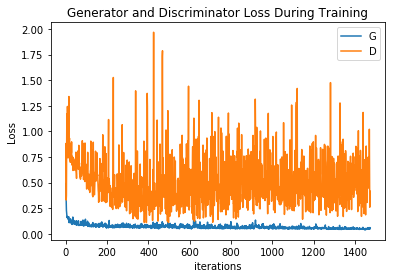

In [36]:
plt.figure(figsize=(10,5))
fig = plt.figure()
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
#fig.savefig('Losses-patch.png')

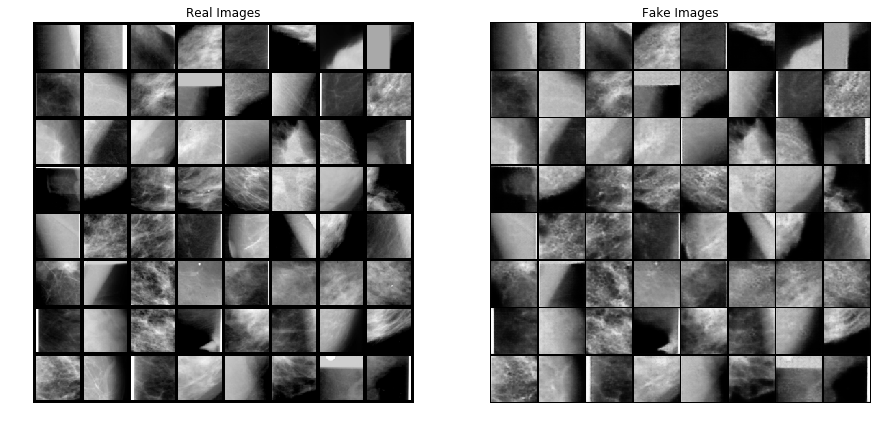

In [37]:

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))  
plt.show()

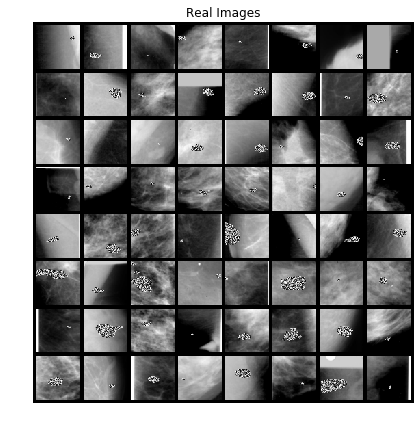

In [38]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(fixed_noise.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

In [39]:
encoder.eval()


DataParallel(
  (module): encoder(
    (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [40]:
decoder.eval()

DataParallel(
  (module): decoder(
    (dec1): ConvTranspose2d(2048, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec5): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [41]:
test_dataset = DDSM(dataroot, dataroot2, 'test',  transform=transform)



test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

In [42]:
test_batch = next(iter(test_loader))

In [43]:
test_maskset = MASKS('./ddsm_masks/test_masks/', transform=transform)

mtest_loader = torch.utils.data.DataLoader(
        test_maskset, batch_size=64, shuffle=True,
        num_workers=10, pin_memory=True)

test_mask = next(iter(mtest_loader))
np.place(test_mask.numpy(),test_mask.numpy()>-1, [1])
np.place(test_mask.numpy(),test_mask.numpy()==-1, [0])

In [44]:
test_noise = createpatch(test_batch[0],test_mask,batch_size)
test_noise = test_noise.to(device)

In [45]:
test_ext_noise = torch.randn(batch_size, nz).to(device=device)
l_proj = (netp(test_ext_noise)).reshape(batch_size, ndf*16, 4, 4)
       

In [46]:
encoded_imgs = encoder(test_noise.float(), test_mask.to(device).float())
fakes = decoder(encoded_imgs.float(), l_proj.float())


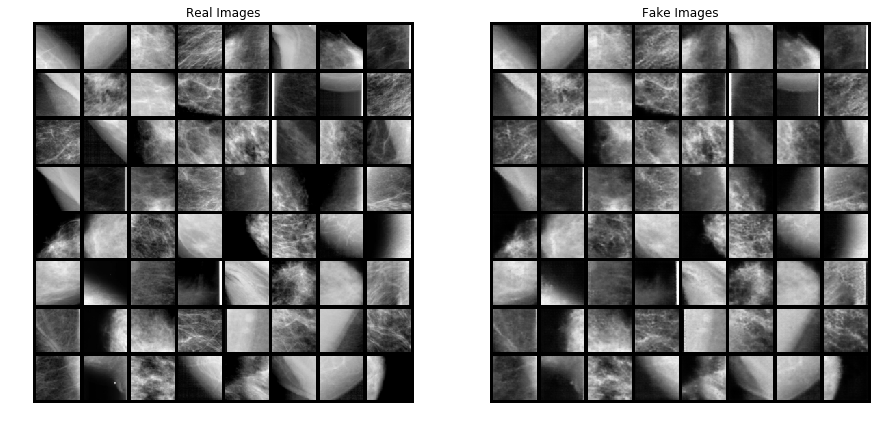

In [47]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fakes.detach().to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

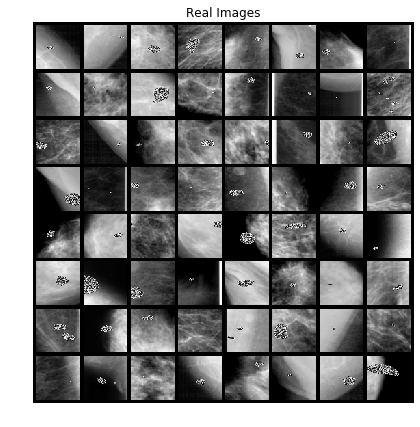

In [48]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_noise.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Load and do evaluation on the trained on 100 epochs model

In [18]:
path= './saved_models/model-DCGAN-BC-AdversarialEncDec-patch-MaskInfilling-BCMasks/'

In [19]:
encoder.load_state_dict(torch.load(path + 'encoder-patch-AE-100e.pth'))
decoder.load_state_dict(torch.load(path + 'decoder-patch-AE-100e.pth'))

netD.load_state_dict(torch.load(path + 'netD-patch-AE-100e.pth'))

In [20]:
encoder.eval()

encoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [21]:
decoder.eval()

decoder(
  (dec1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec5): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [22]:
test_dataset = DDSM(dataroot, dataroot2, 'val',  transform=transform)



test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

In [23]:
test_batch = next(iter(test_loader))

In [24]:
test_maskset = MASKS('./ddsm_masks/val_masks/', transform=transform)

mtest_loader = torch.utils.data.DataLoader(
        test_maskset, batch_size=64, shuffle=True,
        num_workers=10, pin_memory=True)

test_mask = next(iter(mtest_loader))
np.place(test_mask.numpy(),test_mask.numpy()>-1, [1])
np.place(test_mask.numpy(),test_mask.numpy()==-1, [0])

In [25]:
test_noise = createpatch(test_batch[0], test_mask,batch_size)
test_noise = test_noise.to(device)

test_ext_noise = torch.randn(batch_size, nz).to(device=device)
l_proj = (netp(test_ext_noise)).reshape(batch_size, ndf*16, 4, 4)

In [26]:
encoded_imgs = encoder(test_noise.float(), test_mask.to(device).float())
fakes = decoder(encoded_imgs.float(), l_proj.float())


In [27]:
fakes.shape

torch.Size([64, 1, 64, 64])

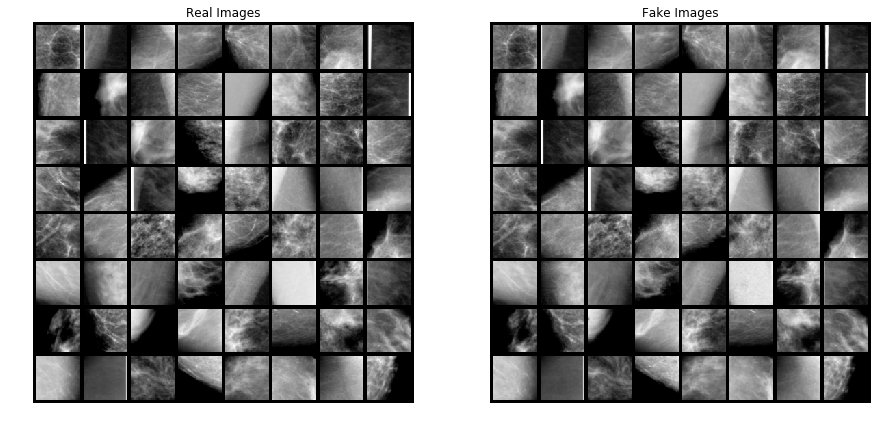

In [28]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fakes.detach().to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [29]:
#vutils.save_image(test_batch[0].to(device)[:64], 'real.png', padding=5, normalize=True)

In [30]:
#vutils.save_image(fakes.detach().to(device)[:64], 'fake.png', padding=5, normalize=True)

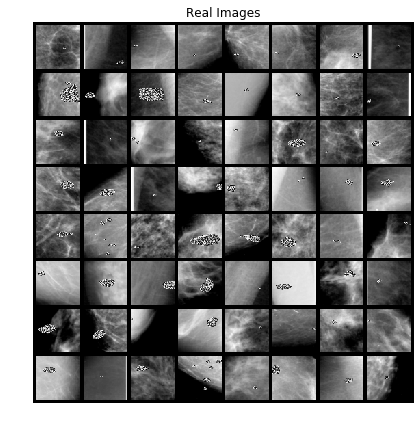

In [31]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_noise.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Save generated & Real images

In [32]:
#for i in range(fakes.shape[0]):

    #vutils.save_image(fakes[i,:,:,:], os.path.join('./generated_images/','{}.png'.format(i)), padding=5, normalize=True)
    

In [33]:
#for i in range(test_batch[0].shape[0]):

    #vutils.save_image(test_batch[0][i,:,:,:], os.path.join('./real_images/','{}.png'.format(i)), padding=5, normalize=True)
    

In [34]:
cou = 0
for j,data in enumerate(test_loader,0):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        for i in range(b_size):
            try:
      
                vutils.save_image(real_cpu[i,:,:,:], os.path.join('./real_images/','{}.png'.format(cou)), padding=5, normalize=True)
                cou = cou + 1


            except:
                print('The last batch is smaller so I ignored the error')
                pass


            
# Ignore the error, it is because the last batch is smaller than 64 images

The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is sm

In [35]:
count = 0 
with torch.no_grad():
    for j, (data,mask) in enumerate(zip((test_loader),(mtest_loader))):

    
        
        # Format batch
        real_cpu = data[0].to(device) 
        b_size = real_cpu.size(0)
        
        
        np.place(mask.numpy(),mask.numpy()>-1, [1])
        np.place(mask.numpy(),mask.numpy()==-1, [0])
        
        masks = mask.to(device)
        
        noise = createpatch(data[0], mask, batch_size)
        noise = noise.to(device)
        
        ext_noise = torch.randn(b_size, nz).to(device=device)
        l_proj = (netp(ext_noise)).reshape(b_size, ndf*16, 4, 4)
        
        encoded_imgs = encoder(noise.float(), masks.float())
        fake = decoder(encoded_imgs.float(), l_proj.float())
        for i in range(b_size):
            try:
                vutils.save_image(fake[i,:,:,:], os.path.join('./generated_images/','{}.png'.format(count)), padding=5, normalize=True)
                count = count + 1
                
            except:
                print('The last batch is smaller so I ignored the error')
                pass

The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is sm